## LSTM/GRU Ten Day Prediction.
### Discharge is the only input. 
##### A rolling approach is taken. The RNN's are capable of making 1 day predictions with startling accuracy, even with peak discharges. 
##### The networks will make their predictions, which are then recorded as ground truths, on which the next '1-day' prediction is made. This is repeated until a 10-day prediciton is achieved. 
#### .
##### Pro's: 
##### 1) This method could be used for beyond 10 days, or shorter too; with each iteration giving results that are visually understandable. Explaining how this works to a non-coder would be easy, and easy to show. 
##### 2) Given sufficient cuda horsepower, this approach can be brute forced for superior results (i.e. more epochs, more neurons, more layers). 
##### 3) Due to the linear nature of input and output, the model is especially sensitive to changes; allowing for easily understood tinkering (for instance changing the loss function). 
##### 4) As the main intention behind this model is flood prediction; increasing the neurons, layers and epochs produces a usually-unwanted phenomenon of 'overfitting'. However, the overfit predictions tend to predict peaks 0-5% higher than actual. This is very useful for flood prediction. If a better (sMAPE) score is wanted, or smaller peak discharge values, then reducing the neurons and epochs gives that. 
##### Con's: 
##### 1) Lengthy to train without sufficient graphics card support. This can be sped up by reducing the number of neurons in a layer (presently its at 128), and by reducing the number of years the model studies (presently its at 10 years). 
##### 2) Completely reliant on discharge values, which in many watersheds aren't reliably present. THe model has demosntrated substantial sensitivity to 'dubious zeros' (a discharge recording of '0', which isn't representative of the actual discharge; i.e. the sensor was malfunctioning). 
##### 3) No relationship between values other than discharge are revealed in the model, should hypothetical situations wish to be tested (e.g. "In a La Nina year with more rapid melt in a shorter snow melt time window...) 



### LSTM sMAPE score of: 0.06257926
### GRU sMAPE score of: 0.05651551
### Combined sMAPE score of: 

##### The dataset being used in this Google Colab notebook is: (https://drive.google.com/file/d/1WCJfLM28Truqx332Gfo8I7orQ_owhYjr/view?usp=sharing) 

In [ ]:
# Import relevant libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the relevant .csv file to local drive. Note! This is a modified version 
!cp /content/drive/MyDrive/EDAs/HYSETS_important.csv /content/

In [ ]:
# Load the dataframe
df = pd.read_csv('HYSETS_important.csv')
df.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,0,6.4,-27.2,-38.9,NaN
1,1950-01-02,0,1.3,-27.8,-39.4,NaN
2,1950-01-03,0,0.0,-15.6,-41.1,NaN
3,1950-01-04,0,0.0,-15.0,-21.7,NaN
4,1950-01-05,0,0.0,-12.2,-26.1,NaN


In [ ]:
# Isolating a single watershed. 
shed205 = df[(df.watershed == 205)]
# Switching the 'time' column to the datetime format.
shed205["time"] = pd.to_datetime(shed205["time"])

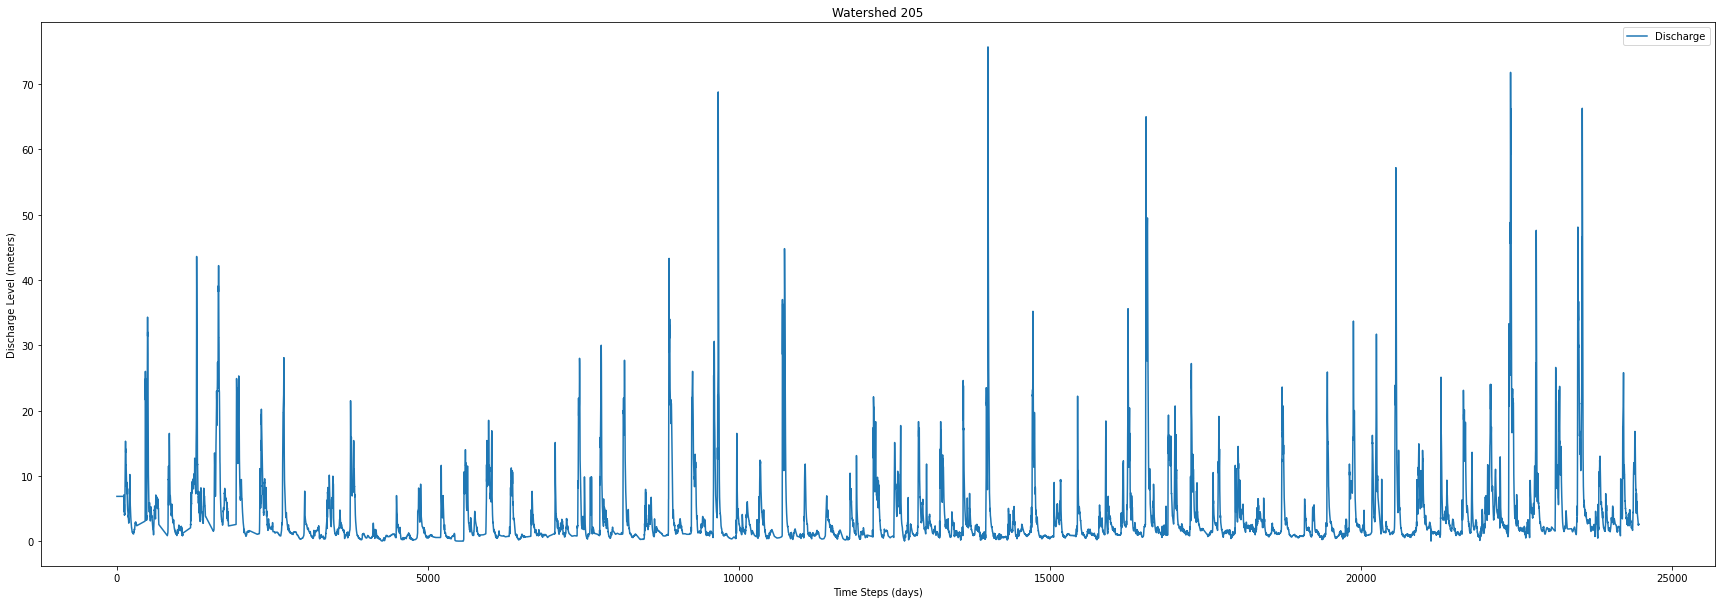

In [ ]:
# For visual representation, plotting discharge of watershed 8

x = range(len(shed205))
y1 = shed205.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 205")
plt.xlabel("Time Steps (days)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (meters)")
plt.plot(y1, label = 'Discharge')




plt.legend()
plt.show()

In [ ]:
# We will use the last ten years of discharge recordings. 
shed205 = shed205[(shed205.time > '2007-12-31') & (shed205.time < '2017-01-01')]

In [ ]:
# Using Pandas built in function 'interpolate', nan values will be filled in. 
shed205.set_index('time', inplace = True)
for watershedID in set(shed205["watershed"]):
  shed205[shed205["watershed"] == watershedID] = shed205[shed205["watershed"] == watershedID].interpolate(method='time', axis=0, limit_direction="both")

In [ ]:
# For experimentation, using a copy saves reloading time. 
model1 = shed205.copy()

In [ ]:
model1.reset_index(inplace=True) 
model1.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,2008-01-01,205,0.123591,-16.483820,-30.757202,1.30
1,2008-01-02,205,0.245303,-3.820251,-31.308037,1.31
2,2008-01-03,205,0.000000,-0.565344,-11.674008,1.33
3,2008-01-04,205,0.000000,-1.030793,-11.786221,1.28
4,2008-01-05,205,0.000000,0.398956,-10.096242,1.27


In [ ]:
df = model1.copy()
err = df[['discharge']]
err.head()

,discharge
0,1.30
1,1.31
2,1.33
3,1.28
4,1.27


In [ ]:
# Transform features by scaling each feature to a given range, to help it become more accurate.
scaler = MinMaxScaler(feature_range=(-1, 1))
err['discharge'] = scaler.fit_transform(err['discharge'].values.reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
t = 20 # (Which will be the 21st term)
# Take the first 20
err_20 = err.discharge[0:t]
target = err.discharge[t:t+1]
print(target)

20   -0.969038
Name: discharge, dtype: float64


In [ ]:
# Create a function that will split the data into training and testing. 
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [ ]:
# Split the data into train and test groups.
lookback = 20 # Choose a sequence length. Each timestep is approximately 3 days, so 20 = ~ 60 days/ 2 months.
x_train, y_train, x_test, y_test = split_data(err, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2614, 19, 1)
y_train.shape =  (2614, 1)
x_test.shape =  (654, 19, 1)
y_test.shape =  (654, 1)


In [ ]:
# Turn the train and test groups into tensors for use in Pytorch. 
# Herein we will also twin the test group into a GRU and LSTM group.
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
# Now we create the internals of the Deep Learning modles. 
input_dim = 1 # Dimension of input data
hidden_dim = 128 # Number of neurons in a given layer. 
num_layers = 2 # Number of layers.
output_dim = 1 # The output dimension of the data.
num_epochs = 1000 # The number training epochs. With diminishing returns, more is better. 
#                   However, too much more will often lead to overfitting. 

In [ ]:
# Create a function/class that will be our Pytorch LSTM model. 
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
# Instantiating the model, and establishing loss and optimization functions. 
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean') # The loss calculation function.
optimiser = torch.optim.Adam(model.parameters(), lr=0.01) # THe optimization calculation function. 

In [ ]:
# Execute the model.
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    if t%100 == 0:
      print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.8006398677825928
Epoch  100 MSE:  0.00390902953222394
Epoch  200 MSE:  0.002812191378325224
Epoch  300 MSE:  0.0012768842279911041
Epoch  400 MSE:  0.000714064750354737
Epoch  500 MSE:  0.0007186406292021275
Epoch  600 MSE:  0.0006436915718950331
Epoch  700 MSE:  0.0006072292453609407
Epoch  800 MSE:  0.0005908689345233142
Epoch  900 MSE:  0.0005527522880584002
Training time: 1966.5443043708801


In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

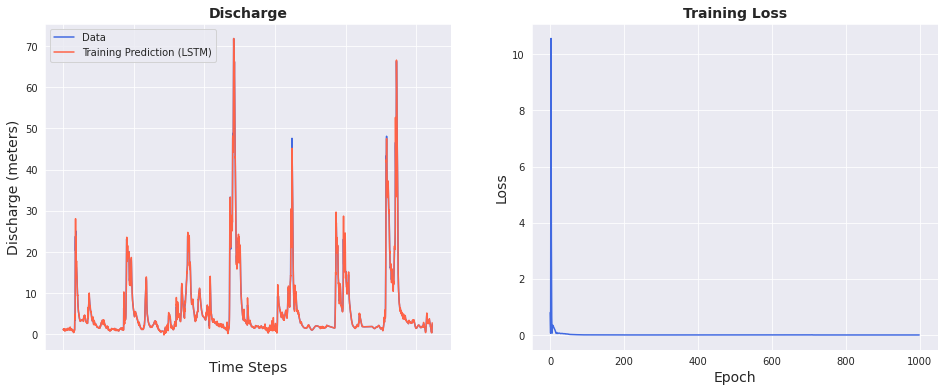

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Discharge', size = 14, fontweight='bold')
ax.set_xlabel("Time Steps", size = 14)
ax.set_ylabel("Discharge (meters)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


In [ ]:


# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 0.82 RMSE
Test Score: 0.59 RMSE



#### Now to observe predictions on the test data. 

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(err)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(err)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(err)-1, :] = y_test_pred

original = scaler.inverse_transform(err['discharge'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Discharge (meters)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [ ]:
#SMAPE scoring for test dataset. 

n = len(y_test) 
total = 0
for i in range(len(y_test)):
  top = (y_test_pred[i] - y_test[i])
  bottom = ((y_test_pred[i] + y_test[i]) /2)
  answer = top/bottom
  if answer < 0: 
    answer = answer * -1
  total += answer
SMAPE = total/n
SMAPE

array([0.06257926], dtype=float32)


##### This suggests that with such a simple, computationally inexpensive LSTM, error can be predicted quite well.

### Now to test the Gated Recurrent Unit.

In [ ]:
# Create the GRU class for Pytorch
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
# Instantiate, create a loss and optimation function.
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_gru)
    if t%100 == 0:
      print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time    
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.7394130229949951
Epoch  100 MSE:  0.001043518539518118
Epoch  200 MSE:  0.0008607269846834242
Epoch  300 MSE:  0.0008191415690816939


In [ ]:
predict2 = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original2 = pd.DataFrame(scaler.inverse_transform(y_train_gru.detach().numpy()))

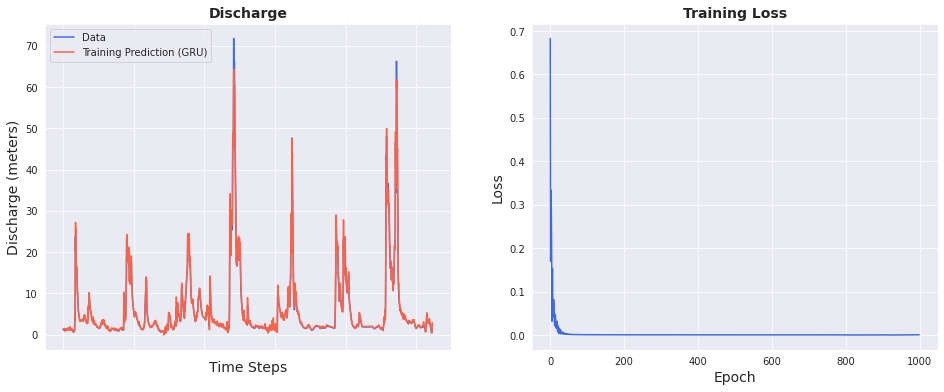

In [ ]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original2.index, y = original2[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict2.index, y = predict2[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Discharge', size = 14, fontweight='bold')
ax.set_xlabel("Time Steps", size = 14)
ax.set_ylabel("Discharge (meters)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
# make predictions
y_test_pred2 = model(x_test)

# invert predictions
y_train_pred2 = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train2 = scaler.inverse_transform(y_train_gru.detach().numpy())
y_test_pred2 = scaler.inverse_transform(y_test_pred2.detach().numpy())
y_test2 = scaler.inverse_transform(y_test_gru.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred2[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
gru.append(trainScore)
gru.append(testScore)
gru.append(training_time)

AttributeError: ignored

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(err)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred2)+lookback, :] = y_train_pred2

# shift test predictions for plotting
testPredictPlot = np.empty_like(err)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred2)+lookback-1:len(err)-1, :] = y_test_pred2

original2 = scaler.inverse_transform(err['discharge'].values.reshape(-1,1))

predictions2 = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions2 = np.append(predictions, original, axis=1)
result2 = pd.DataFrame(predictions2)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result2.index, y=result2[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result2.index, y=result2[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result2.index, y=result2[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Discharge (Cubic Meters)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (GRU)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [ ]:
#SMAPE scoring for test dataset. 

n = len(y_test) 
total = 0
for i in range(len(y_test)):
  top = (y_test_pred[i] - y_test[i])
  bottom = ((y_test_pred[i] + y_test[i]) /2)
  answer = top/bottom
  if answer < 0: 
    answer = answer * -1
  total += answer
SMAPE = total/n
SMAPE

array([0.05651551], dtype=float32)

In [ ]:
# Comparing the two models side by side. 
lstm = pd.DataFrame(lstm, columns=['LSTM'])
gru = pd.DataFrame(gru, columns=['GRU'])
result = pd.concat([lstm, gru], axis=1, join='inner')
result.index = ['Train RMSE', 'Test RMSE', 'Train Time']
result

,LSTM,GRU
Train RMSE,0.816842,1.119281
Test RMSE,0.588650,0.592265
Train Time,1966.544304,1443.043330


### Where to from one round?
##### A simple For-Loop can go through both sets of predictions, and take whichever predicted closer to the ground truth 